#**CHAPTER 7**
신경망 . 딥러닝

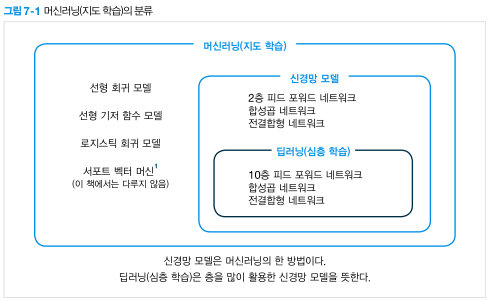

딥러닝: 머신러닝의 일종으로 층을 많이 쌓은 신경망 모델


신경망 모델: 뉴런 모델의 집합체 모델

##**신경망의 구성 요소 :  뉴런 모델**

### 뉴런 모델
정의: 뇌의 신경세포에서 힌트를 얻어 만든 수학적 모델  
기능: 입력 공간을 선으로 나눈다.    
특징: 시냅스의 전달강도에 따라 세포 내부의 전위가 달라진다. 

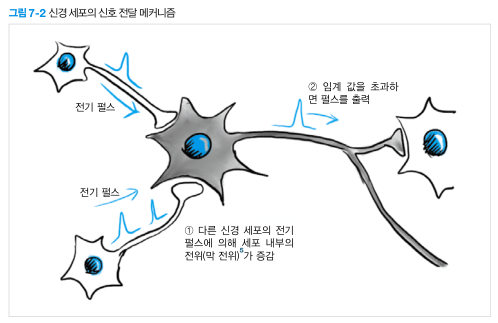

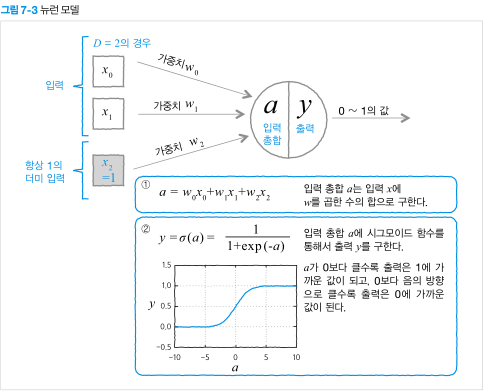

시냅스 전달강도 : 가중치 W  
단위 시간당 펄스 수(발화 빈도) : y 출력값  
임계 값 : bias

##**신경망 모델**

### 2층 피드 포워드 신경망
피드 포워드 신경망: 신호가 되돌아가지 않고 한 방향으로만 흐르는 신경망  
기능: 입력을 3개의 카테고리로 분류  
출력: 각각의 카테고리에 속하는 확률

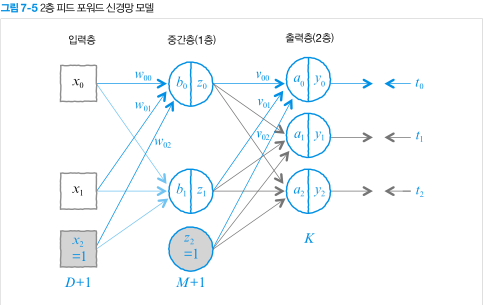

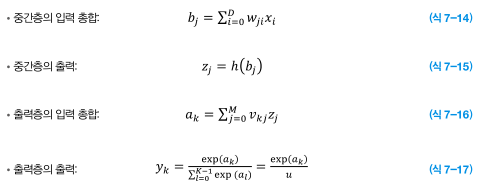

특이점: 중간층 입력의 총합과 출력층 입력의 총합에 바이어스항도 포함시켜줘야 한다.

#### 2층 피드포워드 신경망 구현

In [2]:
#사용할 데이터 생성 : (6장의 3클래스 분류에 사용한 데이터)
# X : 입력 데이터 : [[-0.14, 0.86].......]
# T : 목표 데이터 : [[0 0 1].............]

import numpy as np
np.random.seed(seed=1)
N = 200 ## 데이터 수
K = 3 ## 분포의 수
T = np.zeros((N, 3), dtype=np.uint8) 
X = np.zeros((N, 2))
X_range0 = [-3, 3] ## X0 범위, 표시용
X_range1 = [-3, 3] ## X1 범위, 표시용
Mu = np.array([[-.5, -.5],[.5, 1.0],[1, -.5]]) ## 분포의 중심
Sig = np.array([[.7, .7],[.8, .3],[.3, .8]])  ## 분포의 분산
Pi = np.array([0.4, 0.8, 1]) ## 각 분포에 대한 비율
for n in range(N):
  wk = np.random.rand()
  for k in range(K):
    if wk < Pi[k]:
      T[n, k] = 1
      break
  for k in range(2):
    X[n, k] = np.random.randn() * Sig[T[n, :] == 1,k] + Mu[T[n, :] == 1, k]

In [3]:
## 생성한 데이터를 X_Train, T_train, X_test T_test로 나누어 저장

## 2분류 데이터를 테스트 훈련 데이터로 분할 : 오버피팅 확인 용
TestRatio = 0.5
X_n_training = int(N * TestRatio)
X_train = X[:X_n_training, :]
X_test = X[X_n_training:, :]
T_train = T[:X_n_training, :]
T_test = T[X_n_training:, :]

## 데이터를 class_data.npz에 저장
np.savez('class_data.npz', X_train=X_train, T_train=T_train, 
         X_test=X_test, T_test=T_test, 
         X_range0=X_range0,X_range1=X_range1)

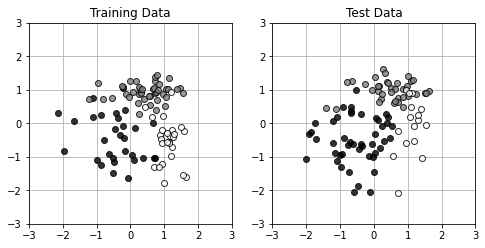

In [4]:
## 분할한 데이터를 그리기
import matplotlib.pyplot as plt

def Show_data(x, t):
  wk, n = t.shape
  c = [[0, 0, 0], [.5, .5, .5], [1, 1, 1]]
  for i in range(n):
    plt.plot(x[t[:, i] == 1,0], x[t[:, i]== 1, 1],
            linestyle ='none',
            marker='o', markeredgecolor='black',
            color=c[i], alpha=0.8) 
    plt.grid(True)

plt.figure(1, figsize=(8, 3.7))
plt.subplot(1, 2, 1)
Show_data(X_train, T_train)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Training Data')
plt.subplot(1, 2, 2)
Show_data(X_test, T_test)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Test Data')
plt.show()

나누는 이유: 모델이 격어보지 못한 데이터를 예측하는 것이 모델평가의 기준이기 때문

In [5]:
## sigmoid 구현
def Sigmoid(x): 
  y = 1 / (1 + np.exp(-x))
  return y
## 2층 피드 포워드 신경망
def FNN(wv, M, K, x):  ## wv 가중치 매개변수, 중간층 노드 수, 출력층 노드 수, 입력
  N, D = x.shape
  w = wv[: M * (D + 1)]
  w = w.reshape(M, (D + 1)) ##  w 가중치
  v = wv[M * (D + 1):]
  v = v.reshape((K, M + 1)) ##  v 가중치
  b = np.zeros((N, M + 1)) # 중간층 뉴런의 입력총합
  z = np.zeros((N, M + 1)) # 중간층 뉴런의 출력
  a = np.zeros((N, K)) # 출력층 뉴런의 입력 총합
  y = np.zeros((N, K)) # 출력층 뉴런의 출력
  for n in range(N):
    #중간층 계산
    for m in range(M): ## np.r_ 은 리스트를 옆으로 붙혀준다.(bias 추가)
      b[n, m] = np.dot(w[m, :], np.r_[x[n, :], 1])  ## w * x
      z[n, m] = Sigmoid(b[n, m]) ## 중간층 activation 출력 
    # 출력층 계산
    z[n, M] =1 # bias 추가
    wkz = 0  ##softmax를 위한 변수
    for k in range(K): 
      a[n, k] = np.dot(v[k, :], z[n, :]) ## v * z
      wkz = wkz + np.exp(a[n, k]) ## softmax 계산용
    for k in range(K): ## softmax 출력 
      y[n, k] = np.exp(a[n, k]) / wkz 
  return y, a, z, b ## 출력층 뉴런의 출력, 출력층 뉴런의 입력총합, 
                    ## 중간층 뉴런의 출력, 중간층 뉴런의 입력총합,

 ##--test 
WV = np.ones(15)
M = 2
K = 3
FNN(WV, M, K, X_train[:2, :])

(array([[0.33333333, 0.33333333, 0.33333333],
        [0.33333333, 0.33333333, 0.33333333]]),
 array([[2.6971835 , 2.6971835 , 2.6971835 ],
        [1.49172649, 1.49172649, 1.49172649]]),
 array([[0.84859175, 0.84859175, 1.        ],
        [0.24586324, 0.24586324, 1.        ]]),
 array([[ 1.72359839,  1.72359839,  0.        ],
        [-1.12079826, -1.12079826,  0.        ]]))

#### 수치 미분법

경사하강법 적용을 위한 오차함수 편미분  
방법 : 아주 작은 수를 + - 해서 근사 기울기를  구한다.  
장점: 쉽게 미분 값을 구할 수 있다.  
단점: 계산비용이 크다

분류 문제 :평균 교차 엔트로피 오차

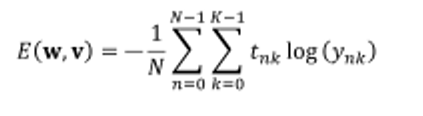

In [6]:
## 평균 교차 엔트로피 오차
def CE_FNN(wv, M, K, x, t):  ## wv 가중치 매개변수, 중간층 노드 수, 출력층 노드 수, 입력, 정답입력
  N, D = x.shape
  y, a, z, b = FNN(wv, M, K, x) ## 2층 피드 포워드 신경망, y: 출력층 뉴런의 출력
  ce = -np.dot(np.log(y.reshape(-1)), t.reshape(-1)) / N  ## 같은 위치 요소끼리 곱하고 더하게 된다
  return ce ## 평균 교차 엔트로피 오차
## reshape(-1) : 1차원 배열로 변환(flatten)

WV = np.ones(15)
M = 2
K = 3
CE_FNN(WV, M, K, X_train[:2, :], T_train[:2, :])

1.0986122886681098

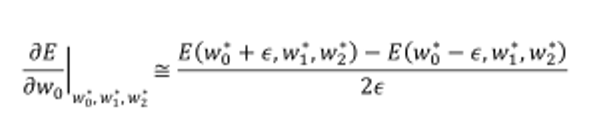

[ 0.0884813   0.19157999 -0.05139799  0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115648 -0.10104422 -0.09427964 -0.46855603
  0.13096434  0.08076649  0.57971252]


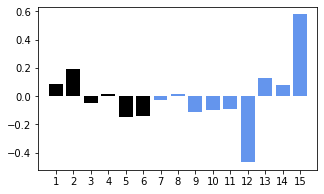

In [7]:
## CE_FNN의 수치 미분 방식
def dCE_FNN_num(wv, M, K, x, t): ## wv 가중치, 중간층 노드, 출력층 노드, 입력, 정답입력
  epsilon = 0.001 ##W에 더하고 뺄 작은 값
  dwv = np.zeros_like(wv) ## wv 수치미분값, wv와 같은 모양, 0으로 초기화
  for iwv in range(len(wv)): 
    wv_modified = wv.copy() ## wv 복사
    wv_modified[iwv] = wv[iwv] - epsilon ## w - epsilon 
    mse1 = CE_FNN(wv_modified, M, K, x, t) ## E(w - epsilon)
    wv_modified[iwv] = wv[iwv] + epsilon ## w + epsilon
    mse2 = CE_FNN(wv_modified, M, K, x, t) ## E(w + epsilon)
    dwv[iwv] = (mse2 - mse1) / (2 * epsilon) ## dwv 계산
  return dwv ## CE_FNN의 수치미분값

def Show_WV(wv, M): ## 시각화
  N = wv.shape[0]
  plt.bar(range(1, M * 3 + 1), wv[:M * 3], align="center", color='black')
  plt.bar(range(M * 3 + 1, N + 1), wv[M * 3:], align="center", color='cornflowerblue')
  plt.xticks(range(1, N + 1))
  plt.xlim(0, N + 1)

M = 2
K = 3
nWV = M * 3 + K * (M + 1) ## 통합한 매개변수 M * D + 1 + K * (M + 1)
np.random.seed(1)
WV = np.random.normal(0, 1, nWV)
dWV = dCE_FNN_num(WV, M, K, X_train[:2, :], T_train[:2, :])
print(dWV)
plt.figure(1, figsize=(5, 3))
Show_WV(dWV ,M)
plt.show()
## 검은 색은 dw 파란색은 dv

수치 미분법에 의한 경사 하강법

In [8]:
import time

##경사하강법으로 학습하기
## 가중치 초기값, 중간층 노드, 출력층 노드, x는 데이터값 t는 정답값, n = 학습단계값, 학습상수 
def Fit_FNN_num(wv_init, M, K, x_train, t_train, x_test, t_test, n, alpha):
  wvt = wv_init ## 가중치 초기화
  err_train = np.zeros(n) ## 학습 단계별 train 에러 값
  err_test = np.zeros(n) ## 학습 단계별 test 에러 값
  wv_hist = np.zeros((n, len(wv_init))) ## 학습단계별 가중치 값
  epsilon = 0.001 ## 수치미분용 상수
  for i in range(n): ## 설정한 학습 단계만큼 반복
    wvt = wvt - alpha * dCE_FNN_num(wvt, M, K, x_train, t_train) ## 경사하강법 : wvt 갱신
    err_train[i] = CE_FNN(wvt, M, K, x_train, t_train) ## 평균 교차 엔트로피 오차 저장
    err_test[i] = CE_FNN(wvt, M, K, x_test, t_test) ## 평균 교차 엔트로피 오차 저장
    wv_hist[i, :] = wvt ## 가중치 값 저장
  return wvt, wv_hist, err_train, err_test ## 가중치 매개변수, 가중치 기록, train 에러 기록, test 에러 기록

startTime = time.time() ## 시간 측정 시작
M = 2 ## 중간 노드 수
K = 3 ## 출력 노드 수
np.random.seed(1)
WV_init = np.random.normal(0, 0.01, M * 3 + K * (M + 1)) ## 가중치 초기화
N_step = 1000 ## 학습 단계 값
alpha = 0.5 ## 학습 상수
WV, WV_hist, Err_train, Err_test = Fit_FNN_num(
    WV_init, M, K, X_train, T_train, X_test, T_test, N_step, alpha)
calculation_time = time.time() - startTime ## 걸린 시간 계산
print("Calculation time:{0: .3f} sec".format(calculation_time))

Calculation time: 190.807 sec


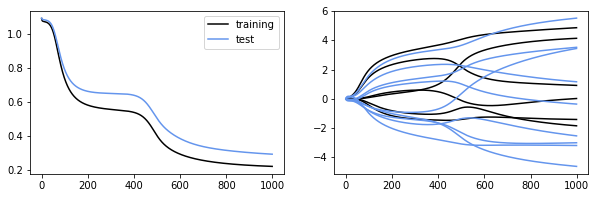

In [9]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(Err_train, 'black', label='training')
plt.plot(Err_test, 'cornflowerblue', label='test') 
## 학습단계에 따른 에러값
plt.legend()
plt.subplot(1,2,2)
plt.figure(1, figsize=(3,3))
plt.plot(WV_hist[:, :M *3], 'black') ## w
plt.plot(WV_hist[:, M *3:], 'cornflowerblue') ## v
## 학습단계에 따른 wv 매개변수 값
plt.show()

가중치가 안정점 지점 근처를 통과하는 증거
- 학습 400단계 부분에서 학습이 수렴하다가 다시 진행되는 모습  
- 가중치 그래프가 400부분에서 교차하고 있음 : 오차함수의 기울기 방향의 변화

안장점

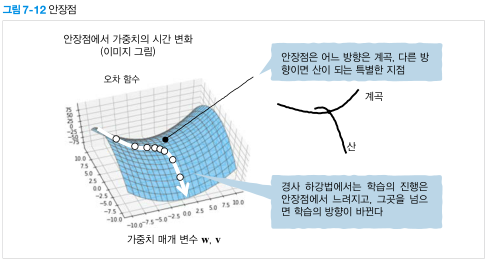

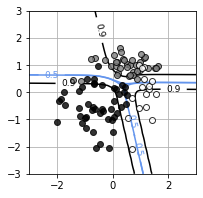

In [10]:
## show_FNN : 데이터 공간에 클래스 0, 1, 2로 판정하는 경계선을 표시하는 함수

def show_FNN(wv, M, K): ## 가중치 매개변수, 중간층 노드수, 출력층 노드수
  xn = 60 ## 등고선 표시 해상도
  x0 = np.linspace(X_range0[0], X_range0[1], xn) ##xn개수만큼 나누기
  x1 = np.linspace(X_range1[0], X_range1[1], xn) ##xn개수만큼 나누기
  xx0, xx1 = np.meshgrid(x0, x1) ## meshgird생성
  x = np.c_[np.reshape(xx0, xn * xn, 'F'), np.reshape(xx1, xn * xn, 'F')] ## x값 생성
  y, a, z, b = FNN(wv, M, K, x) ## 데이터 공간을 입력으로 받는 FNN 생성
  plt.figure(1, figsize=(4, 4))
  for ic in range(K): ## 클래스단위로 contour 그리기
    f = y[:, ic]
    f = f.reshape(xn, xn)
    f = f.T ## meshgrid 영향
    cont = plt.contour(xx0, xx1, f, levels=[0.5, 0.9], ## 파란색은 0.5 이상일 때, 검은색은 0.9이상일 때
                       colors=['cornflowerblue', 'black'])
    cont.clabel(fmt='%1.1f', fontsize=9)
  plt.xlim(X_range0)
  plt.ylim(X_range0)
## --- 경계선 표시
plt.figure(1, figsize=(3, 3))
Show_data(X_test, T_test) ## 데이터 그리기
show_FNN(WV, M, K) ## 경계선 그리기
plt.show()

####오차 역전파법

1. 오차함수 재정의
2. 오차함수, V에 대한 편미분 구하기
3. 오차함수, W에 대한 편미분 구하기
4. 역전파 계산

##### 오차함수 재정의

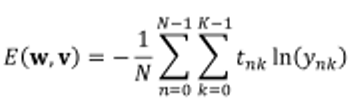

- FNN에서 사용한 평균 교차 엔트로피 오차

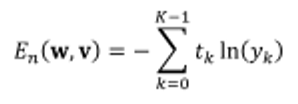

- 하나의 데이터에 해당하는 상호 엔트로피 오차를 정의

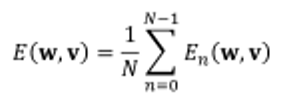

- 오차 함수 재정의

##### v에 대한 오차함수 편미분 구하기

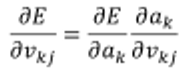

- chain rule로 식 정리  
- a는 입력의 총합이다
- 여기에서 E는 $E_n$ 이다.
- 1항은 upstrem gradient, 2항은 local gradient

###### $a_0$에 대한 오차함수의 편미분 구하기

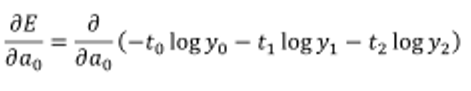

- E: 상호 오차 엔트로피
- y: a의 소프트맥스 결과값
- $t_0$ + $t_1$ + $t_2$를 더하면 1 (softmax 특징)

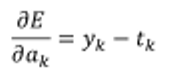

- a에 대한 오차함수 편미분

######v에 대한 a의 편미분 구하기

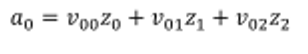

- $a_0$ 는 입력 총합의 일부분

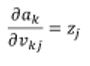

- v에 대한 a의 편미분

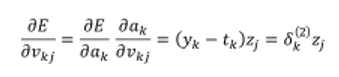

- v에 대한 오차함수의 편미분값

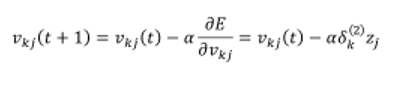

- V의 학습 규칙 : 경사하강법
- 특징 :
    - V는 중간층의 뉴런 j에서 출력층의 뉴런 k에 곱해지는 가중치.
    - 출력층에서의 오차와 중간층에서의 입력의 곱만큼 학습이 진행된다.
    - 오차는 실수, 입력은 양수이다.


##### w에 대한 오차함수 편미분 구하기

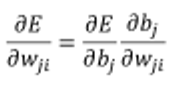

- chain rule로 식 정리  
- b는 입력의 총합이다
- 여기에서 E는 $E_n$ 이다.
- 1항은 upstream gradient, 2항은 local gradient

###### b에 대한 오차함수의 편미분

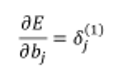

- 앞서 구한 a에 대한 오차함수와 같은 논리로 표시

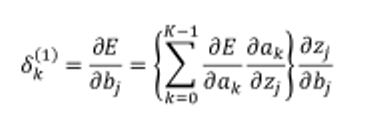

- 앞의 시그마는 중간층와 출력층때문에 발생.(행렬연산)
- 첫번째 항은 위에서 이미 정의했다
- 두번째 항은 입력 총합을 $z_f$로 미분하면 $v_{kj}$가 된다.
- 세번째 항은 중간층의 활성화 함수에 의해 h'($b_f$)로 표기된다. 


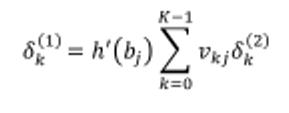

따라서 다음과 같이 정의가 된다.
- 특징:
    - h' : 활성화 함수의 미분으로 항상 양수
    - 오차(2)를 $ v_{kj} $의 가중치로 모으는 형태
- 즉  오차(1)은 오차(2)를 반대방향으로 전달시켜 계산


###### w에 대한 b의 편미분

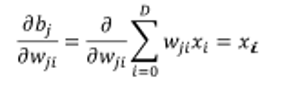

- 앞서 구한 v에 대한 a의 편미분과 같은 논리

##### w의 갱신 규칙 : 경사하강법

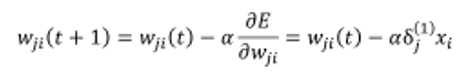

- W의 학습 규칙 : 경사하강법
- 특징 :
    - W는 입력층의 뉴런 i에서 출력층의 뉴런 j에 곱해지는 가중치.
    - 중간층에서의 오차와 입력만큼 학습이 진행.
    - 오차는 실수, 입력은 양수이다.

##### 오차 역전파법 정리

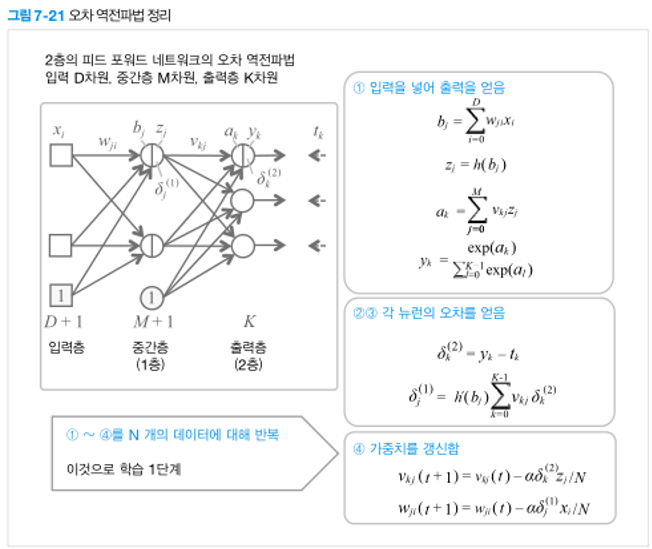

1/N은 N개의 데이터가 있으므로 1~4번 절차를 N번 처리해 학습의 1단계로 하기 때문

####오차 역전파법 구현

In [11]:
## --해석적 미분
def dCE_FNN(wv, M, K, x, t):
  N, D = x.shape
  ## wv를 w와 v로 되돌림
  w = wv[:M * (D + 1)]
  w = w.reshape(M, (D + 1))
  v = wv[M * (D + 1):]
  v = v.reshape(K, (M + 1))
  # x를 FNN에 넣어 y를 얻는다.
  y, a, z, b = FNN(wv, M, K, x)
  # 출력변수 준비
  dwv = np.zeros_like(wv) # wv와 같은 형태, 0값으로 초기화
  dw = np.zeros((M, D + 1))
  dv = np.zeros((K, M + 1))
  delta1 = np.zeros(M) ## 1층 오차
  delta2 = np.zeros(K) ## 2층 오차
  for n in range(N):
    ## 출력층의 오차 구하기
    for k in range(K):
      delta2[k] = (y[n, k] - t[n, k])
    ## 중간층의 오차 구하기
    for j in range(M):
      delta1[j] = z[n, j] * (1 - z[n, j]) * np.dot(v[:, j], delta2)
    ## v의 기울기 dv를 구하기
    for k in range(K):
      dv[k, :] = dv[k, :] + delta2[k] * z[n, :] / N
    ## w의 기울기 dw를 구하기
    for j in range(M):
      dw[j, :] = dw[j, :] + delta1[j] * np.r_[x[n, :], 1] / N ## np.r_는 x에 bias 추가
  ## dw와 dv를 합체시킨 dwv만들기
  dwv = np.c_[dw.reshape((1, M * (D + 1))), dv.reshape(1, K * (M + 1))]
  dwv = dwv.reshape(-1)
  return dwv

In [12]:
def Show_dWV(wv, M): ## dw, dv 시각화
  N = wv.shape[0]
  plt.bar(range(1, M * 3 + 1), wv[:M * 3], align="center", color='black')
  plt.bar(range(M * 3 + 1, N + 1), wv[M * 3:], align="center", color='cornflowerblue')
  plt.xticks(range(1, N + 1)) 
  plt.xlim(0, N + 1)

##### 해석 미분, 수치 미분 방법 비교 

analytical dWV
[ 0.08848131  0.19158    -0.051398    0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115649 -0.10104422 -0.09427964 -0.46855604
  0.13096434  0.08076649  0.57971253]
numerical dWV
[ 0.0884813   0.19157999 -0.05139799  0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115648 -0.10104422 -0.09427964 -0.46855603
  0.13096434  0.08076649  0.57971252]


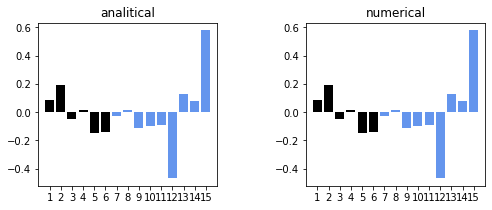

In [13]:
M = 2
K = 3
N = 2
nWV = M * 3 + K * (M + 1)
np.random.seed(1)
WV = np.random.normal(0, 1, nWV)

dWV_ana = dCE_FNN(WV, M, K, X_train[:N, :], T_train[:N, :])
print("analytical dWV")
print(dWV_ana)

dWV_num = dCE_FNN_num(WV, M, K, X_train[:N, :], T_train[:N, :])
print("numerical dWV")
print(dWV_num)

plt.figure(1, figsize=(8, 3))
plt.subplots_adjust(wspace=0.5)
plt.subplot(1, 2, 1)
Show_dWV(dWV_ana, M)
plt.title('analitical')
plt.subplot(1, 2, 2)
Show_dWV(dWV_num, M)
plt.title('numerical')
plt.show()


- 수치 미분과 해석 미분의 값이 거의 일치
  - 수치미분은 해석 미분의 정확도 확인용으로 사용 가능 

In [16]:
import time

def Fit_FNN(wv_init, M, K, x_train, t_train, x_test, t_test, n, alpha):
  wv = wv_init.copy()
  err_train = np.zeros(n)
  err_test = np.zeros(n)
  wv_hist = np.zeros((n, len(wv_init)))
  epsilon = 0.001
  for i in range(n):
    wv = wv - alpha * dCE_FNN(wv, M, K, x_train, t_train)
    err_train[i] = CE_FNN(wv, M, K, x_train, t_train)
    err_test[i] = CE_FNN(wv, M, K, x_test, t_test)
    wv_hist[i, :] = wv
  return wv, wv_hist, err_train, err_test

startTime =time.time()
M = 2
K = 3
np.random.seed(1)
wv_init = np.random.normal(0, 0.01, M * 3 + K * (M + 1))
N_step = 1000
alpha = 1
WV, wv_hist, Err_train, Err_test = Fit_FNN(
    WV_init, M, K, X_train, T_train, X_test, T_test, N_step, alpha)
calculation_time = time.time() - startTime
print("Calculation time:{0: .3f} sec".format(calculation_time))

Calculation time: 24.314 sec


- 계산 시간: 수치미분 <<< 해석미분

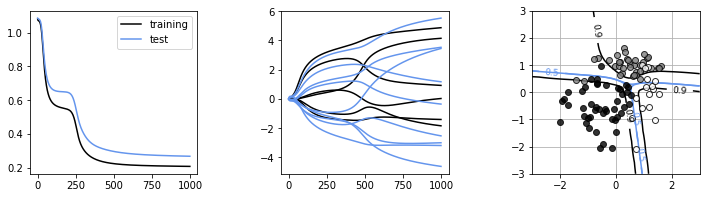

In [17]:
plt.figure(1, figsize= (12, 3))
plt.subplots_adjust(wspace=0.5)
plt.subplot(1, 3, 1)
plt.plot(Err_train, 'black', label='training')
plt.plot(Err_test, 'cornflowerblue', label = 'test')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(WV_hist[:, :M * 3], 'black')
plt.plot(WV_hist[:, M * 3:], 'cornflowerblue')
plt.subplot(1, 3, 3)
Show_data(X_test, T_test)
M = 2
K = 3
show_FNN(WV, M, K)
plt.show()

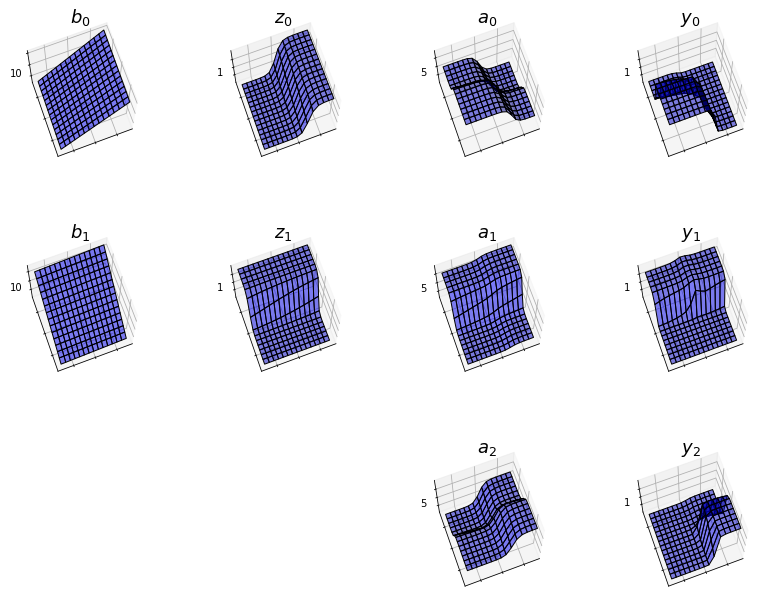

In [21]:
def show_activation3d(ax, v, v_ticks, title_str):
  f = v.copy()
  f = f.reshape(xn, xn)
  f = f.T
  ax.plot_surface(xx0, xx1, f, color='blue', edgecolor='black', rstride=1, cstride=1, alpha=0.5)
  ax.view_init(70, -110)
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.set_zticklabels(v_ticks)
  ax.set_title(title_str, fontsize=18) 
M = 2
K = 3
xn = 15
x0 = np.linspace(X_range0[0], X_range0[1], xn)
x1 = np.linspace(X_range1[0], X_range1[1], xn)
xx0, xx1 = np.meshgrid(x0, x1)
x = np.c_[np.reshape(xx0, xn * xn, 'F'), np.reshape(xx1, xn * xn, 'F')]
y, a, z, b = FNN(WV, M, K, x)

fig = plt.figure(1, figsize=(12, 9))
plt.subplots_adjust(left=0.075, bottom=0.05, right= 0.95, top = 0.95, wspace=0.4, hspace=0.4)

for m in range(M):
  ax = fig.add_subplot(3, 4, 1 + m * 4, projection = '3d')
  show_activation3d(ax, b[:, m], [-10, 10], '$b_{0:d}$'.format(m))
  ax = fig.add_subplot(3, 4, 2 + m * 4, projection = '3d')
  show_activation3d(ax, z[:, m], [0, 1], '$z_{0:d}$'.format(m))

for k in range(K):
  ax = fig.add_subplot(3, 4, 3 + k * 4, projection = '3d')
  show_activation3d(ax, a[:, k], [-5, 5], '$a_{0:d}$'.format(k))
  ax = fig.add_subplot(3, 4, 4 + k * 4, projection = '3d')
  show_activation3d(ax, y[:, k], [0, 1], '$y_{0:d}$'.format(k))

plt.show()

b : 중간층 입력총합  
z : 중간층 출력  
a : 출력층 입력총합  
y : 출력층 출력  
- 특징 : 
  - b: W에 의해 면 기울기가 결정
  - z: 시그모이드 함수를 통과 (0 ~ 1 출력)
  - a: z의 조합으로 구성
  - y: a의 소프트맥스 결과물(0 ~ 1 출력), 각 y요소 하나당 클레스 분류 범위를 의미, 전부 더하면 높이가 1인 평면

### 케라스로 신경망 모델 구현

In [22]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import time
np.random.seed(1)
import keras.optimizers
from keras.models import Sequential
from keras.layers.core import Dense, Activation

outfile = np.load('class_data.npz')
X_train = outfile['X_train']
T_train = outfile['T_train']
X_test = outfile['X_test']
T_test = outfile['T_test']
X_range0 = outfile['X_range0']
X_range1 = outfile['X_range1']

In [25]:
def Show_data(x, t):
  wk, n = t.shape
  c = [[0, 0, 0], [.5, .5, .5], [1, 1, 1]]
  for i in range(n):
    plt.plot(x[t[:, i] == 1,0], x[t[:, i]== 1, 1],
            linestyle ='none',
            marker='o', markeredgecolor='black',
            color=c[i], alpha=0.8) 
    plt.grid(True)

In [28]:
np.random.seed(1)

model = Sequential()
model.add(Dense(2, input_dim=2, activation='sigmoid', kernel_initializer='uniform'))
model.add(Dense(3, activation='softmax', kernel_initializer='uniform'))
sgd = keras.optimizers.SGD(lr= 1, momentum=0.0, decay=0.0, nesterov=False)
model.compile(optimizer= sgd, loss='categorical_crossentropy', metrics=['accuracy'])

startTime = time.time()
history = model.fit(X_train, T_train, epochs=1000, batch_size= 100, verbose=0, validation_data=(X_test, T_test))

score = model.evaluate(X_test, T_test, verbose=0)
print('cross entropy {0:3.2f}, accuracy {1:3.2f}'.format(score[0], score[1]))
calculation_time = time.time() - startTime
print("Calculation time:{0: .3f} sec".format(calculation_time))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


cross entropy 0.26, accuracy 0.90
Calculation time: 29.735 sec


책하고 많이 다른 결과;;; 해석미분 정도의 성능

#### 케라스 사용의 흐름

1. import
2. Sequential 모델 생성
3. layer 쌓기
4. compile 으로 학습방법 설정
5. fit 으로 학습 실행
6. evaluate 으로 모델 평가


```
import keras.optimizers  
from keras.models import Sequential  
from keras.layers.core import Dense, Activation  
```  
- optimizers: optimizer 설정
- Sequential: 순차적으로 레이어를 쌓아 만드는 네트워크 모델
- Dense: FC layer
- Activation: 활성화함수 layer : Dense에 포함되어 있다.






```
model = Sequential()
```
- Sequential 클래스로 model객체 생성  
- 여기에 layer 추가하여 네트워크 구조를 정의





```
model.add(Dense(2, input_dim=2, activation='sigmoid', kernel_initializer='uniform'))
```
- FC layer를 Sequential model에 추가
- 2: 뉴런의 개수
- input_dim: 입력 바로 다음 층이므로 입력차원 입력
- activation = 'sigmoid': 활성화 함수로 시그모이드 사용
- kernel_initializer = 'uniform': 가중치 매개변수 초기값을 균일 난수로 설정
- bias는 기본적으로 설정되어 신경쓸 필요 x




```
model.add(Dense(3, activation='softmax', kernel_initializer='uniform'))
```
- 3: 뉴런의 개수
- activatiob='softmax': 활성화 함수로 소프트맥스 사용
- kernel_initializer='uniform': 가중치 매개변수 초기값을 균일 난수로 설정



```
sgd = keras.optimizers.SGD(lr= 1, momentum=0.0, decay=0.0, nesterov=False)
```
- 학습 방법을 설정: 여기에서는 순수한 sgd를 사용한다.





```
model.compile(optimizer= sgd, loss='categorical_crossentropy', metrics=['accuracy'])
```
- 학습방법에 대한 설정
- optimizer = sgd : sgd를 optimizer로 설정
- loss ='categorical_crossentropy' : 교차앤트로피를 목적함수로 설정
- metrics=['accuracy']: 정답률을 학습의 평가로 사용
  - 정답률: 예측 확률이 가장 높은 클래스를 예측할 때 모든 데이터에 대해 몇 %가 정답인지의 비율
  




```
history = model.fit(X_train, T_train, epochs=1000, batch_size= 100, verbose=0, validation_data=(X_test, T_test))
```
- 학습 실행
- X_train: 훈련 입력 데이터
- T_train: 훈련 목표 데이터
- batch_size=100: 1단계분의 기울기를 계산하는데 사용하는 학습 데이터 수
- epochs=1000: 전체 데이터를 학습에 사용한 횟수
- verbose=0: 학습 진행상황을 표시하지 않음
- validation_data=(X_test, T_test): 평가용 데이터의 지정
- history: 학습 과정의 정보




```
score = model.evaluate(X_test, T_test, verbose=0)
```
- 학습의 평가값을 출력
- score[0]은 테스트 데이터의 상호 엔트로피 오차
- score[1]은 데스트 데이터의 정답률


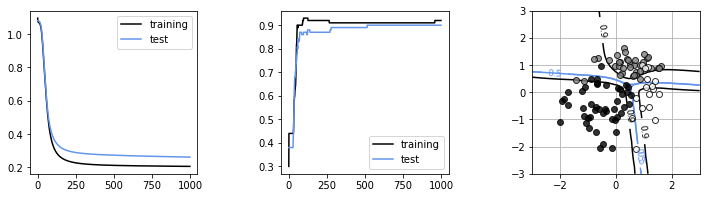

In [41]:
plt.figure(1, figsize=(12, 3))
plt.subplots_adjust(wspace=0.5)

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], 'black', label='training')
plt.plot(history.history['val_loss'], 'cornflowerblue', label='test')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], 'black', label='training')
plt.plot(history.history['val_accuracy'], 'cornflowerblue', label='test')
plt.legend()

plt.subplot(1, 3, 3)
Show_data(X_test, T_test)
xn = 60
x0 = np.linspace(X_range0[0], X_range0[1], xn)
x1 = np.linspace(X_range1[0], X_range1[1], xn)
xx0, xx1 = np.meshgrid(x0, x1)
x = np.c_[np.reshape(xx0, xn * xn, 'F'), np.reshape(xx1, xn * xn, 'F')]
y = model.predict(x)
K = 3
for ic in range(K):
  f = y[:, ic]
  f = f.reshape(xn, xn)
  f = f.T
  cont = plt.contour(xx0, xx1, f, levels=[0.5, 0.9], colors=['cornflowerblue', 'black'])
  cont.clabel(fmt='%1.1f', fontsize=9)
  plt.xlim(X_range0)
  plt.ylim(X_range1)
plt.show() 


In [37]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

1. 학습단계별 오차
  - 오차가 빠르게 감소 && 테스트 데이터 오차도 감소
  - 오버피팅은 x
2. 학습 단계별 정답률
  - 학습이 잘 될수록 정답률은 1에 가까워짐
  - 네트워크 성능평가에 주로 정답률을 사용
3. 데이터 공간상의 모델
  - 클래스별 경계를 모델이 잘 나타내고 있다.    